<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [96]:
# Check for GPU
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [97]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.mps.is_available() else "cpu"
device

2.9.1


'mps'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

- **increase model complexity** - by adding more layers or units to model
- **reduce regularization and dropout** - these are techniques to reduce overfitting 
- **use transfer learning** - find something useful from other models
- **train the model longer** - give it more time to learn the patterns of data

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [98]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else: 
  print(f"Did not find {image_path} directory, creating...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak, suhsi data to {image_path}")
  zip_ref.extractall(image_path) 

data/pizza_steak_sushi directory exists.
Unzipping pizza, steak, suhsi data to data/pizza_steak_sushi


In [99]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [100]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [101]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

pizza
Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


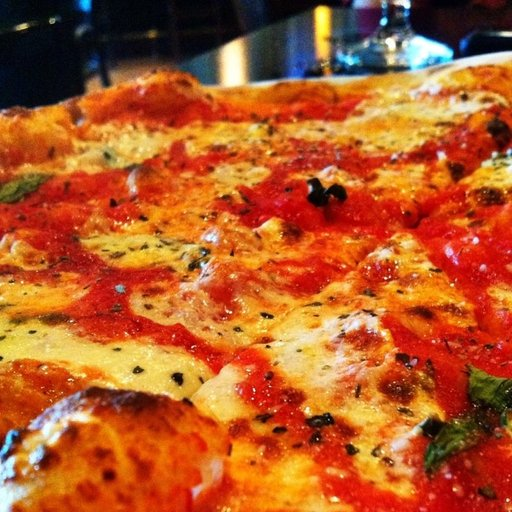

In [102]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

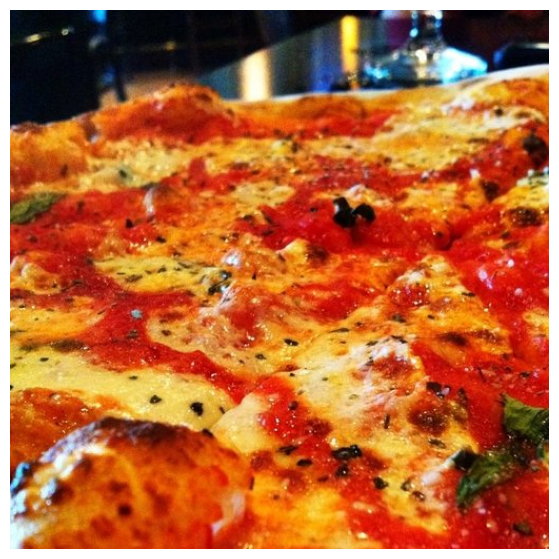

In [103]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt
import numpy

img_as_array = numpy.asarray(img)

plt.figure(figsize=(9,7))
plt.imshow(img_as_array)
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [104]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [105]:
# Write transform for turning images into tensors

data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

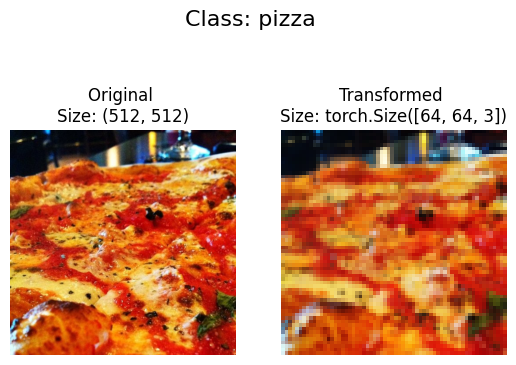

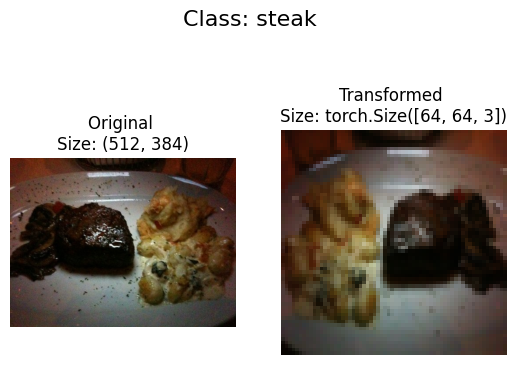

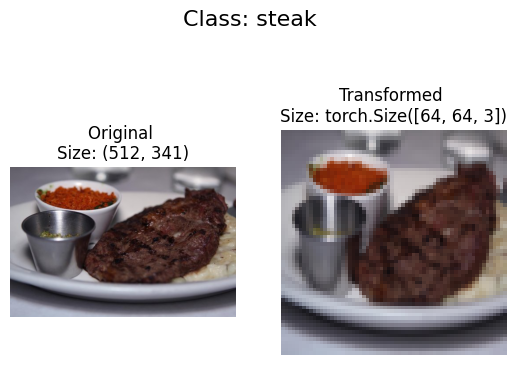

In [106]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### Load image data using `ImageFolder`

In [107]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [108]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [109]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [110]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [111]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=5,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1742016f0>,
 <torch.utils.data.dataloader.DataLoader at 0x174202380>)

In [112]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [113]:
class TinyVGG(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,
                      hidden_units,
                      3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)                     
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,
                      hidden_units,
                      3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)                     
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    def forward(self,x):
        return self.classifier(self.block2(self.block1(x)))
        

## 4. Create training and testing functions for `model_0`.

In [114]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send data to target device
    X,y = X.to(device),y.to(device)
    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred,y)
    train_loss += loss
    # 3. Optimizer zero grad 
    optimizer.zero_grad()    

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1) # y_pred -> softmaxed probs -> argmax to get results
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader) 
  train_acc /= len(dataloader) 

  return train_loss, train_acc

In [115]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0
  
  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to target device
      X,y = X.to(device),y.to(device)
      # 1. Forward pass
      y_pred = model(X)
      # 2. Calculate and accumulate loss
      loss = loss_fn(y_pred,y)
      test_loss += loss

      # Calculate and accumulate accuracy
      y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1) # y_pred -> softmaxed probs -> argmax to get results
      test_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader) 
  test_acc = test_acc / len(dataloader) 

  return test_loss, test_acc

In [116]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [117]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

 20%|██        | 1/5 [00:29<01:58, 29.66s/it]

Epoch: 1 | train_loss: 1.1178 | train_acc: 0.2800 | test_loss: 1.0975 | test_acc: 0.4133


 40%|████      | 2/5 [00:56<01:24, 28.27s/it]

Epoch: 2 | train_loss: 1.0994 | train_acc: 0.2667 | test_loss: 1.0992 | test_acc: 0.2667


 60%|██████    | 3/5 [01:24<00:55, 27.91s/it]

Epoch: 3 | train_loss: 1.0822 | train_acc: 0.4133 | test_loss: 1.1716 | test_acc: 0.3733


 80%|████████  | 4/5 [01:51<00:27, 27.72s/it]

Epoch: 4 | train_loss: 1.0593 | train_acc: 0.5067 | test_loss: 1.0051 | test_acc: 0.5067


100%|██████████| 5/5 [02:19<00:00, 27.83s/it]

Epoch: 5 | train_loss: 0.9458 | train_acc: 0.5511 | test_loss: 0.9685 | test_acc: 0.4533


In [94]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

  5%|▌         | 1/20 [00:26<08:32, 26.98s/it]

Epoch: 1 | train_loss: 1.1180 | train_acc: 0.2933 | test_loss: 1.0966 | test_acc: 0.3200


 10%|█         | 2/20 [00:53<08:03, 26.84s/it]

Epoch: 2 | train_loss: 1.0998 | train_acc: 0.2667 | test_loss: 1.0995 | test_acc: 0.2800


 15%|█▌        | 3/20 [01:20<07:35, 26.82s/it]

Epoch: 3 | train_loss: 1.1003 | train_acc: 0.3689 | test_loss: 1.1045 | test_acc: 0.2667


 20%|██        | 4/20 [01:47<07:08, 26.80s/it]

Epoch: 4 | train_loss: 1.0931 | train_acc: 0.3778 | test_loss: 1.0593 | test_acc: 0.4933


 25%|██▌       | 5/20 [02:14<06:41, 26.77s/it]

Epoch: 5 | train_loss: 1.0287 | train_acc: 0.5333 | test_loss: 1.0219 | test_acc: 0.4933


 30%|███       | 6/20 [02:40<06:15, 26.81s/it]

Epoch: 6 | train_loss: 0.9337 | train_acc: 0.5644 | test_loss: 1.0521 | test_acc: 0.5067


 35%|███▌      | 7/20 [03:07<05:48, 26.83s/it]

Epoch: 7 | train_loss: 0.8737 | train_acc: 0.6000 | test_loss: 0.9990 | test_acc: 0.4133


 40%|████      | 8/20 [03:34<05:22, 26.87s/it]

Epoch: 8 | train_loss: 0.8514 | train_acc: 0.6089 | test_loss: 1.0001 | test_acc: 0.4267


 45%|████▌     | 9/20 [04:01<04:55, 26.82s/it]

Epoch: 9 | train_loss: 0.8175 | train_acc: 0.6400 | test_loss: 0.9953 | test_acc: 0.4800


 50%|█████     | 10/20 [04:28<04:28, 26.88s/it]

Epoch: 10 | train_loss: 0.7227 | train_acc: 0.6622 | test_loss: 1.0380 | test_acc: 0.4933


 55%|█████▌    | 11/20 [04:55<04:01, 26.85s/it]

Epoch: 11 | train_loss: 0.7254 | train_acc: 0.7200 | test_loss: 1.0486 | test_acc: 0.4667


 60%|██████    | 12/20 [05:22<03:34, 26.87s/it]

Epoch: 12 | train_loss: 0.6259 | train_acc: 0.7600 | test_loss: 1.1381 | test_acc: 0.4933


 65%|██████▌   | 13/20 [05:49<03:08, 26.95s/it]

Epoch: 13 | train_loss: 0.5072 | train_acc: 0.7733 | test_loss: 1.2216 | test_acc: 0.5067


 70%|███████   | 14/20 [06:16<02:41, 26.94s/it]

Epoch: 14 | train_loss: 0.5036 | train_acc: 0.7644 | test_loss: 1.0947 | test_acc: 0.6000


 75%|███████▌  | 15/20 [06:43<02:14, 26.92s/it]

Epoch: 15 | train_loss: 0.4328 | train_acc: 0.8311 | test_loss: 1.4161 | test_acc: 0.4933


 80%|████████  | 16/20 [07:09<01:47, 26.88s/it]

Epoch: 16 | train_loss: 0.3872 | train_acc: 0.8622 | test_loss: 1.5800 | test_acc: 0.5200


 85%|████████▌ | 17/20 [07:36<01:20, 26.87s/it]

Epoch: 17 | train_loss: 0.3899 | train_acc: 0.8489 | test_loss: 1.4470 | test_acc: 0.5333


 90%|█████████ | 18/20 [08:03<00:53, 26.88s/it]

Epoch: 18 | train_loss: 0.2507 | train_acc: 0.8978 | test_loss: 1.9993 | test_acc: 0.5600


 95%|█████████▌| 19/20 [08:30<00:26, 26.88s/it]

Epoch: 19 | train_loss: 0.2518 | train_acc: 0.9289 | test_loss: 2.1208 | test_acc: 0.4800


100%|██████████| 20/20 [08:57<00:00, 26.86s/it]

Epoch: 20 | train_loss: 0.2546 | train_acc: 0.9111 | test_loss: 2.4546 | test_acc: 0.4933


In [ ]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [118]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [119]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.


Excellent, we now have double the training and testing images... 

In [120]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [121]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(root=train_data_20_percent_path,
                         transform=simple_transform)
test_data_20_percent = ImageFolder(root=test_data_20_percent_path,
                         transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(dataset=train_data_20_percent,
                                 batch_size=32,
                                 num_workers=10,
                                 shuffle=True)
test_dataloader_20_percent = DataLoader(dataset=test_data_20_percent,
                                        batch_size=32,
                                        num_workers=10,
                                        shuffle=False)
train_dataloader_20_percent,test_dataloader_20_percent

(<torch.utils.data.dataloader.DataLoader at 0x177c17ac0>,
 <torch.utils.data.dataloader.DataLoader at 0x30095e050>)

In [122]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(),
                             lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

  5%|▌         | 1/20 [01:22<26:00, 82.14s/it]

Epoch: 1 | train_loss: 1.1042 | train_acc: 0.3312 | test_loss: 1.1004 | test_acc: 0.2875


 10%|█         | 2/20 [02:41<24:06, 80.38s/it]

Epoch: 2 | train_loss: 1.0831 | train_acc: 0.3917 | test_loss: 1.0687 | test_acc: 0.4500


 15%|█▌        | 3/20 [04:00<22:36, 79.79s/it]

Epoch: 3 | train_loss: 1.0287 | train_acc: 0.4437 | test_loss: 0.9548 | test_acc: 0.5267


 20%|██        | 4/20 [05:19<21:11, 79.46s/it]

Epoch: 4 | train_loss: 0.9130 | train_acc: 0.5479 | test_loss: 0.9115 | test_acc: 0.5875


 25%|██▌       | 5/20 [06:38<19:49, 79.33s/it]

Epoch: 5 | train_loss: 0.8619 | train_acc: 0.6229 | test_loss: 0.9353 | test_acc: 0.4835


 30%|███       | 6/20 [07:57<18:29, 79.22s/it]

Epoch: 6 | train_loss: 0.8235 | train_acc: 0.6583 | test_loss: 1.0266 | test_acc: 0.4994


 35%|███▌      | 7/20 [09:16<17:10, 79.27s/it]

Epoch: 7 | train_loss: 0.8993 | train_acc: 0.5813 | test_loss: 0.8948 | test_acc: 0.5466


 40%|████      | 8/20 [10:36<15:52, 79.39s/it]

Epoch: 8 | train_loss: 0.7741 | train_acc: 0.6813 | test_loss: 0.8778 | test_acc: 0.5949


 45%|████▌     | 9/20 [11:56<14:34, 79.51s/it]

Epoch: 9 | train_loss: 0.7818 | train_acc: 0.6583 | test_loss: 0.9398 | test_acc: 0.5239


 50%|█████     | 10/20 [13:15<13:14, 79.47s/it]

Epoch: 10 | train_loss: 0.8014 | train_acc: 0.6521 | test_loss: 0.8936 | test_acc: 0.6040


 55%|█████▌    | 11/20 [14:34<11:54, 79.37s/it]

Epoch: 11 | train_loss: 0.7545 | train_acc: 0.6667 | test_loss: 0.8949 | test_acc: 0.6131


 60%|██████    | 12/20 [15:54<10:35, 79.41s/it]

Epoch: 12 | train_loss: 0.6808 | train_acc: 0.7104 | test_loss: 0.8882 | test_acc: 0.6256


 65%|██████▌   | 13/20 [17:13<09:16, 79.46s/it]

Epoch: 13 | train_loss: 0.6496 | train_acc: 0.7271 | test_loss: 0.8947 | test_acc: 0.6159


 70%|███████   | 14/20 [18:33<07:56, 79.46s/it]

Epoch: 14 | train_loss: 0.5611 | train_acc: 0.7604 | test_loss: 1.0669 | test_acc: 0.5517


 75%|███████▌  | 15/20 [19:52<06:36, 79.26s/it]

Epoch: 15 | train_loss: 0.5121 | train_acc: 0.8125 | test_loss: 1.1035 | test_acc: 0.5477


 80%|████████  | 16/20 [21:11<05:16, 79.20s/it]

Epoch: 16 | train_loss: 0.5379 | train_acc: 0.7833 | test_loss: 1.1176 | test_acc: 0.5364


 85%|████████▌ | 17/20 [22:30<03:57, 79.14s/it]

Epoch: 17 | train_loss: 0.5205 | train_acc: 0.7875 | test_loss: 1.0853 | test_acc: 0.5301


 90%|█████████ | 18/20 [23:49<02:38, 79.11s/it]

Epoch: 18 | train_loss: 0.4414 | train_acc: 0.8313 | test_loss: 1.4512 | test_acc: 0.5176


 95%|█████████▌| 19/20 [25:08<01:19, 79.11s/it]

Epoch: 19 | train_loss: 0.4558 | train_acc: 0.8292 | test_loss: 1.0567 | test_acc: 0.5460


100%|██████████| 20/20 [26:27<00:00, 79.37s/it]

Epoch: 20 | train_loss: 0.3662 | train_acc: 0.8542 | test_loss: 1.2486 | test_acc: 0.5352


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [130]:
import torchvision
img = torchvision.io.read_image("data/my_data/sirloin-steak-recipe.jpg")
img

tensor([[[246, 239, 228,  ..., 207, 203, 202],
         [240, 234, 225,  ..., 186, 189, 192],
         [232, 228, 223,  ..., 162, 167, 173],
         ...,
         [223, 228, 232,  ..., 112, 153, 183],
         [227, 231, 234,  ..., 111, 156, 182],
         [229, 233, 235,  ..., 110, 157, 180]],

        [[235, 228, 217,  ..., 188, 184, 183],
         [229, 223, 214,  ..., 167, 170, 173],
         [221, 217, 212,  ..., 143, 148, 154],
         ...,
         [190, 195, 199,  ...,  81, 122, 152],
         [194, 198, 201,  ...,  80, 125, 151],
         [196, 200, 202,  ...,  79, 126, 149]],

        [[239, 232, 221,  ..., 190, 186, 185],
         [233, 227, 218,  ..., 169, 172, 175],
         [225, 221, 216,  ..., 145, 150, 156],
         ...,
         [159, 164, 168,  ...,  61, 102, 132],
         [163, 167, 170,  ...,  62, 105, 131],
         [165, 169, 171,  ...,  61, 106, 129]]], dtype=torch.uint8)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

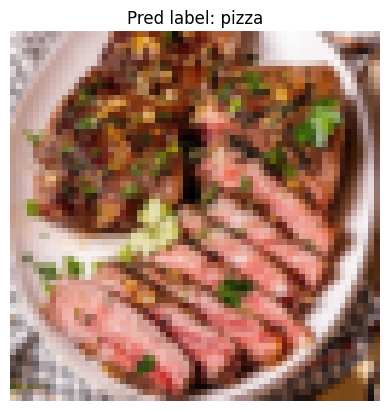

In [131]:
model_4.eval()
with torch.inference_mode():
    # Get image pixels into float + between 0 and 1
  img = img / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device) # add a "1" dim in dim 0

  # Predict on image
  y_pred_logit = model_4(batch) 

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0)) # matplotlib默认是HWC，torch是CHW
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False)

难绷，这里也是预测的依托。。。
增加数据量也是一种办法，但是我认为也可以提高数据质量，这种马赛克图像还是有点不行。
可以尝试使用清晰一点的图像，不过肯定也有别的方法，比如改进模型架构。